## Initialize imports

In [19]:
import os
import glob
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

### Initializing a class for loading in the data 

In [2]:
class TumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_images_from_folders(dataset_path):
    healthy_images = glob.glob(os.path.join(dataset_path, "healthy", "*.jpg")) + \
                     glob.glob(os.path.join(dataset_path, "healthy", "*.png"))
    tumor_images = glob.glob(os.path.join(dataset_path, "tumor", "*.jpg")) + \
                   glob.glob(os.path.join(dataset_path, "tumor", "*.png"))
    
    image_paths = healthy_images + tumor_images
    labels = [0] * len(healthy_images) + [1] * len(tumor_images)
    return image_paths, labels

### Configuring our training, testing, and validation dataset

In [3]:
dataset_path = "./Dataset/"

image_paths, labels = load_images_from_folders(dataset_path)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


### Initializing a class for Image Processing

In [28]:
from torchvision import transforms

class ImagePreprocessor:
    def __init__(self, grayscale=True, resize=(224, 224), horizontal_flip=False, 
                 rotation=0, normalize=None, brightness=None, contrast=None):
        transforms_list = []
        
        if grayscale:
            transforms_list.append(transforms.Grayscale(num_output_channels=1))
        
        if resize:
            transforms_list.append(transforms.Resize(resize))
        
        if horizontal_flip:
            transforms_list.append(transforms.RandomHorizontalFlip())
        
        if rotation > 0:
            transforms_list.append(transforms.RandomRotation(rotation))
        
        if brightness or contrast:
            transforms_list.append(transforms.ColorJitter(brightness=brightness, contrast=contrast))
        
        transforms_list.append(transforms.ToTensor())

        if normalize:
            transforms_list.append(transforms.Normalize(mean=normalize["mean"], std=normalize["std"]))

        self.transform = transforms.Compose(transforms_list)

    def __call__(self, image):
        return self.transform(image)

In [29]:
preprocessor = ImagePreprocessor(
    grayscale=True, 
    resize=(224, 224), 
    horizontal_flip=True, 
    rotation=10, 
    normalize={"mean": [0.5], "std": [0.5]}, 
    brightness=0.2, 
    contrast=0.2
)

train_dataset = TumorDataset(X_train, y_train, transform=preprocessor)
val_dataset = TumorDataset(X_val, y_val, transform=preprocessor)
test_dataset = TumorDataset(X_test, y_test, transform=preprocessor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Total images: 800
Training images: 560
Validation images: 120
Testing images: 120


### Visualizing the preprocessed photos

In [31]:
import matplotlib.pyplot as plt

In [32]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

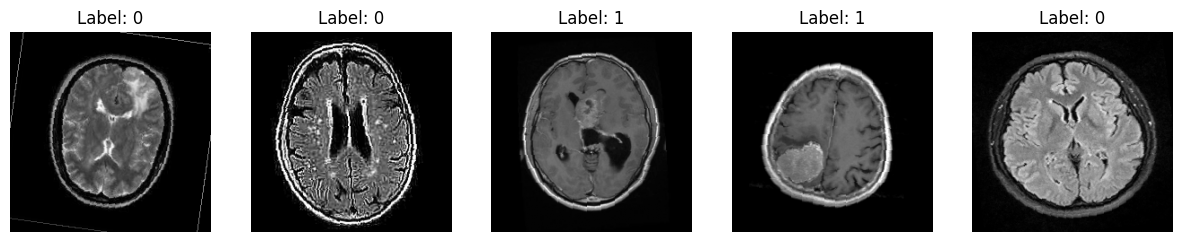

In [33]:
visualize_samples(train_dataset)

In [10]:
def visualize_raw_samples(image_paths, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image = Image.open(image_paths[i]).convert("RGB")
        label = labels[i]
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

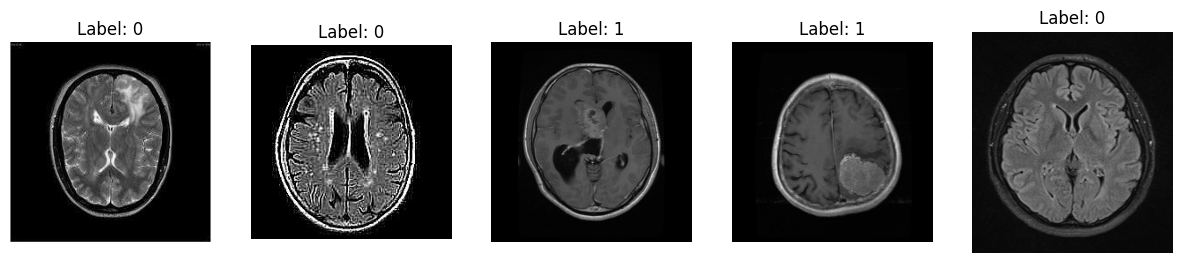

In [11]:
visualize_raw_samples(X_train, y_train)

## Prepare a model 
### Using the current preprocessing kwargs which are tunable for future iterations

In [35]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {100 * correct/total:.2f}%")
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

## Using a CNN model as a baseline

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss: 0.4436, Accuracy: 67.32%
Epoch 2/10, Loss: 0.0339, Accuracy: 87.86%
Epoch 3/10, Loss: 0.0234, Accuracy: 84.82%
Epoch 4/10, Loss: 0.0131, Accuracy: 90.36%
Epoch 5/10, Loss: 0.0205, Accuracy: 83.39%
Epoch 6/10, Loss: 0.0212, Accuracy: 91.07%
Epoch 7/10, Loss: 0.0116, Accuracy: 91.43%
Epoch 8/10, Loss: 0.0062, Accuracy: 95.36%
Epoch 9/10, Loss: 0.0055, Accuracy: 94.11%
Epoch 10/10, Loss: 0.0040, Accuracy: 96.43%


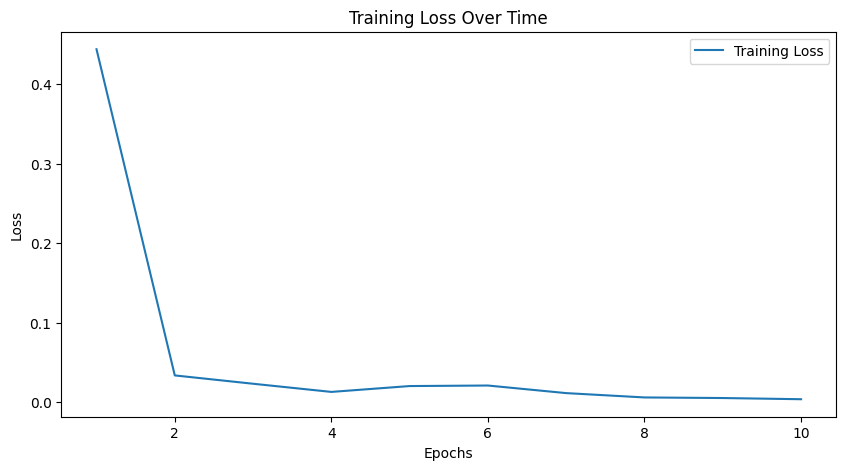

In [37]:
dataloaders = {'train': train_loader, 'val': val_loader}
train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Accuracy: 0.8667
Precision: 1.0000
Recall (Sensitivity): 0.7288
F1 Score: 0.8431
F0.5 Score (Precision-focused): 0.9307
F2 Score (Recall-focused): 0.7706


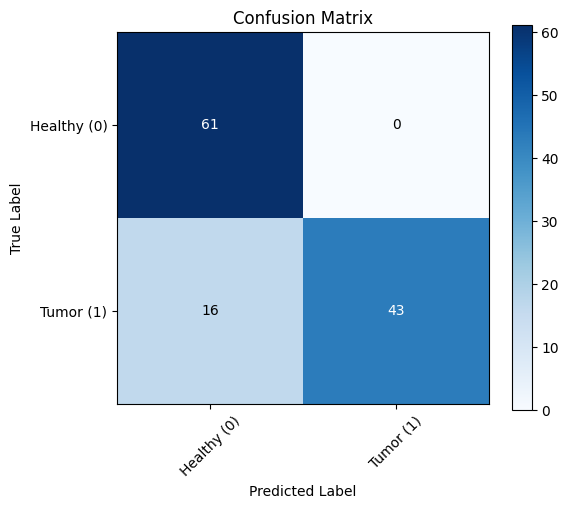

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f05 = fbeta_score(y_true, y_pred, beta=0.5)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F0.5 Score (Precision-focused): {f05:.4f}")
    print(f"F2 Score (Recall-focused): {f2:.4f}")

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    classes = ["Healthy (0)", "Tumor (1)"]
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate Model on Test Set
y_true, y_pred = evaluate_model(model, test_loader, device)

# Print Metrics
print_metrics(y_true, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred)

## Lets shoot to increase our recall/ F2 score -- this focuses on allowing more false positives through the gate
### I will enhance the model, use more rigorous preprocessing, and tune differently

In [40]:
preprocessor = ImagePreprocessor(
    grayscale=True, 
    resize=(224, 224), 
    horizontal_flip=True, 
    rotation=30,  # Increased rotation
    normalize={"mean": [0.5], "std": [0.5]}, 
    brightness=0.4,  # Increased brightness variation
    contrast=0.4,  # Increased contrast variation
)
train_dataset = TumorDataset(X_train, y_train, transform=preprocessor)
val_dataset = TumorDataset(X_val, y_val, transform=preprocessor)
test_dataset = TumorDataset(X_test, y_test, transform=preprocessor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

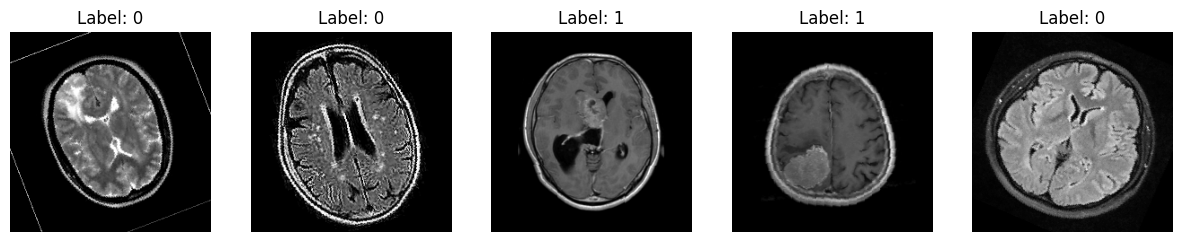

In [41]:
visualize_samples(train_dataset)

In [43]:
class CNNModel2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.dropout = nn.Dropout(0.5)  # Helps generalization

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  
        return x
def train_model(model, criterion, optimizer, dataloaders, num_epochs=15):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {100 * correct/total:.2f}%")
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()


Epoch 1/15, Loss: 0.0206, Accuracy: 63.93%
Epoch 2/15, Loss: 0.0174, Accuracy: 79.46%
Epoch 3/15, Loss: 0.0151, Accuracy: 82.68%
Epoch 4/15, Loss: 0.0132, Accuracy: 82.86%
Epoch 5/15, Loss: 0.0124, Accuracy: 85.54%
Epoch 6/15, Loss: 0.0129, Accuracy: 84.82%
Epoch 7/15, Loss: 0.0114, Accuracy: 86.61%
Epoch 8/15, Loss: 0.0104, Accuracy: 86.96%
Epoch 9/15, Loss: 0.0108, Accuracy: 87.50%
Epoch 10/15, Loss: 0.0116, Accuracy: 85.36%
Epoch 11/15, Loss: 0.0105, Accuracy: 88.39%
Epoch 12/15, Loss: 0.0104, Accuracy: 87.50%
Epoch 13/15, Loss: 0.0103, Accuracy: 88.21%
Epoch 14/15, Loss: 0.0106, Accuracy: 87.32%
Epoch 15/15, Loss: 0.0114, Accuracy: 86.61%


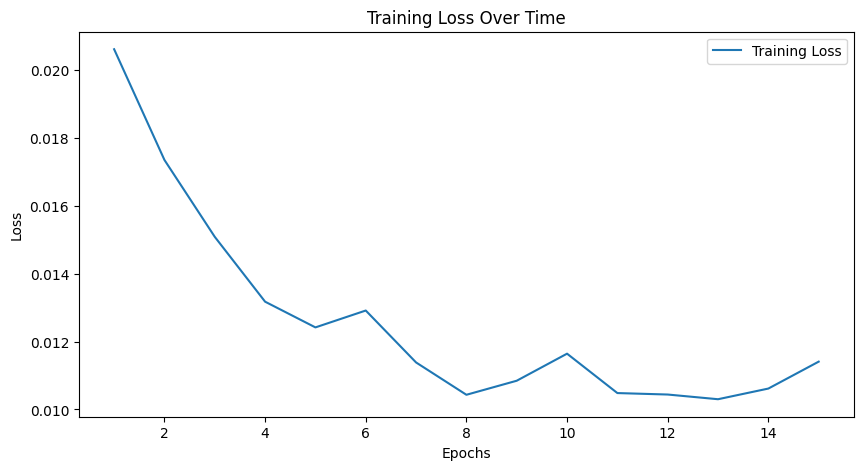

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel2(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower learning rate for stability

dataloaders = {'train': train_loader, 'val': val_loader}
train_model(model, criterion, optimizer, dataloaders, num_epochs=15)


Accuracy: 0.8500
Precision: 0.8060
Recall (Sensitivity): 0.9153
F1 Score: 0.8571
F0.5 Score (Precision-focused): 0.8257
F2 Score (Recall-focused): 0.8911


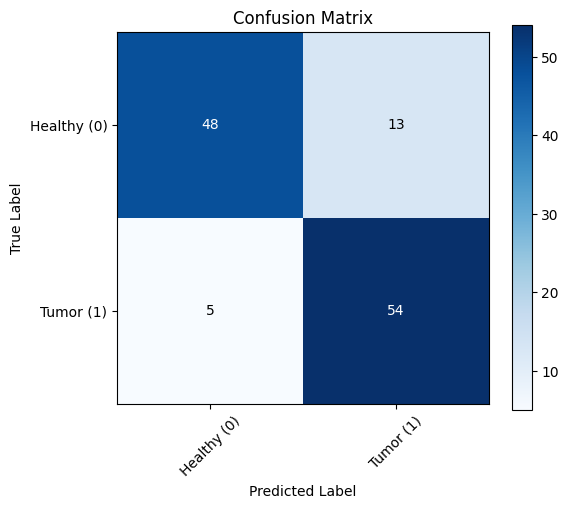

In [45]:
# Evaluate Model on Test Set
y_true, y_pred = evaluate_model(model, test_loader, device)

# Print Metrics
print_metrics(y_true, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred)

## The increase in recall was the objective -- further tuning to increase the model performance will be required. However, I will move forward with this for the sake of full project dev